In [1]:
import cupy as cp
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, hinge_loss
import matplotlib.pyplot as plt
from sklearn.utils import resample
import matplotlib.colors
from sklearn.inspection import DecisionBoundaryDisplay

In [3]:
column_names = ["duration",
 "protocol_type",
 "service",
 "flag",
 "src_bytes",
 "dst_bytes",
 "land",
 "wrong_fragment",
 "urgent",
 "hot",
 "num_failed_logins",
 "logged_in",
 "num_compromised",
 "root_shell",
 "su_attempted",
 "num_root",
 "num_file_creations",
 "num_shells",
 "num_access_files",
 "num_outbound_cmds",
 "is_host_login",
 "is_guest_login",
 "count",
 "srv_count",
 "serror_rate",
 "srv_serror_rate",
 "rerror_rate",
 "srv_rerror_rate",
 "same_srv_rate",
 "diff_srv_rate",
 "srv_diff_host_rate",
 "dst_host_count",
 "dst_host_srv_count",
 "dst_host_same_srv_rate",
 "dst_host_diff_srv_rate",
 "dst_host_same_src_port_rate",
 "dst_host_srv_diff_host_rate",
 "dst_host_serror_rate",
 "dst_host_srv_serror_rate",
 "dst_host_rerror_rate",
 "dst_host_srv_rerror_rate",
 "attack_type",
 "attack_index"]

## Hai tập dữ liệu NSL-KDD và UNSW-NB15

In [4]:
df_train = pd.read_csv('/kaggle/input/nslkdd/KDDTrain.txt', names = column_names)
df_test = pd.read_csv('/kaggle/input/nslkdd/KDDTest.txt', names = column_names)

In [2]:
df_train = pd.read_csv('/kaggle/input/unsw-nb15/UNSW_NB15_training-set.csv')
df_test = pd.read_csv('/kaggle/input/unsw-nb15/UNSW_NB15_testing-set.csv')

## Xử lý lớp nhãn NSL-KDD

In [5]:
# Phân loại nhị phân
df_train['label'] = df_train['attack_type'].apply(lambda x: 'anomaly' if x != 'normal' else 'normal')
df_test['label'] = df_test['attack_type'].apply(lambda x: 'anomaly' if x != 'normal' else 'normal')

# Chuyển giá trị từ 'normal' và 'anomaly' -> binary '0', '1'
df_train["label"] = df_train["label"].map({'normal': 0, 'anomaly': 1})
df_test['label'] = df_test['label'].map({'normal': 0, 'anomaly': 1})

In [6]:
X_train = df_train.drop(columns='attack_type')
y_train = df_train['label']

X_test = df_test.drop(columns='attack_type')
y_test = df_test['label']

## Xử lý lớp nhãn UNSW-NB15

In [3]:
X_train = df_train.drop(columns='attack_cat')
y_train = df_train['label']

X_test = df_test.drop(columns='attack_cat')
y_test = df_test['label']

## Mã hóa đặc trưng NSL-KDD

In [7]:
from sklearn.preprocessing import LabelEncoder

columns = ['protocol_type', 'service', 'flag']

# Áp dụng Label Encoding
for col in columns:
    label_encoder = LabelEncoder()
    X_train[col] = label_encoder.fit_transform(X_train[col])
    
    # Xử lý các giá trị chưa thấy trong df_test[col]
    unseen_values = set(X_test[col]) - set(label_encoder.classes_)
    if unseen_values:
        print(f"Warning: Unseen values in column '{col}': {unseen_values}")
        # Thêm các giá trị chưa thấy vào classes_ (giữ nguyên lớp hiện có)
        label_encoder.classes_ = np.append(label_encoder.classes_, list(unseen_values))
    
    X_test[col] = label_encoder.transform(X_test[col])

## Mã hóa đặc trưng UNSW-NB15

In [4]:
from sklearn.preprocessing import LabelEncoder

columns = ['proto', 'service', 'state']

# Áp dụng Label Encoding
for col in columns:
    label_encoder = LabelEncoder()  # Khởi tạo riêng cho mỗi cột
    X_train[col] = label_encoder.fit_transform(X_train[col])
    
    # Xử lý các giá trị chưa thấy trong df_test[col]
    unseen_values = set(X_test[col]) - set(label_encoder.classes_)
    if unseen_values:
        print(f"Warning: Unseen values in column '{col}': {unseen_values}")
        # Thêm các giá trị chưa thấy vào classes_ (giữ nguyên lớp hiện có)
        label_encoder.classes_ = np.append(label_encoder.classes_, list(unseen_values))
    
    X_test[col] = label_encoder.transform(X_test[col])

## Chuẩn hóa StandardScaler() cho tập dữ liệu

In [5]:
scaler = StandardScaler()
X_train_scaled  = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
X_train_scaled_gpu = cp.asarray(X_train_scaled)
y_train_gpu = cp.asarray(y_train)
# Chuyển đổi các mảng cupy sang các mảng numpy
X_train_scaled_numpy = cp.asnumpy(X_train_scaled_gpu)
y_train_numpy = cp.asnumpy(y_train_gpu)

## Thử nghiệm với tập dữ liệu NSL-KDD

### Huấn luyên mô hình

In [11]:
# Evaluate Cross-validated model
# clf_svm_cv = SVC(random_state=42, **optimal_params.best_params_)

clf_svm_cv = SVC(random_state=42, C=100, gamma=0.1, kernel='rbf')
start_time = time.time()
clf_svm_cv.fit(X_train_scaled_numpy, y_train_numpy)
end_time = time.time()

training_time = end_time - start_time
print(f"Thời gian huấn luyện: {training_time:.4f} giây")

Thời gian huấn luyện: 45.5052 giây


### Đánh giá với tập kiểm thử

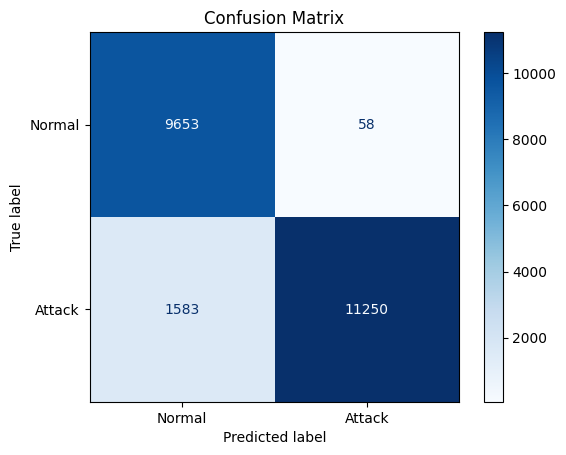

In [12]:
y_test_pred = clf_svm_cv.predict(X_test_scaled)
# Tính ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_test_pred)

# Hiển thị ma trận nhầm lẫn
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Attack'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [13]:
# Tập kiểm tra
y_test_pred = clf_svm_cv.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
loss = hinge_loss(y_test, y_test_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')
print(f'Hinge Loss: {loss}')

Accuracy: 0.9272090134847409
Precision: 0.9948708878669968
Recall: 0.8766461466531599
F1-Score: 0.9320243569031937
Hinge Loss: 0.5035486160397445


## Thử nghiệm với tập UNSW-NB15

### Huấn luyện mô hình

In [7]:
# Evaluate Cross-validated model
# clf_svm_cv = SVC(random_state=42, **optimal_params.best_params_)

clf_svm_cv = SVC(random_state=42, C=100, gamma=0.1, kernel='rbf')
start_time = time.time()
clf_svm_cv.fit(X_train_scaled_numpy, y_train_numpy)
end_time = time.time()

training_time = end_time - start_time
print(f"Thời gian huấn luyện: {training_time:.4f} giây")

Thời gian huấn luyện: 123.9592 giây


### Đánh giá với tập kiểm thử

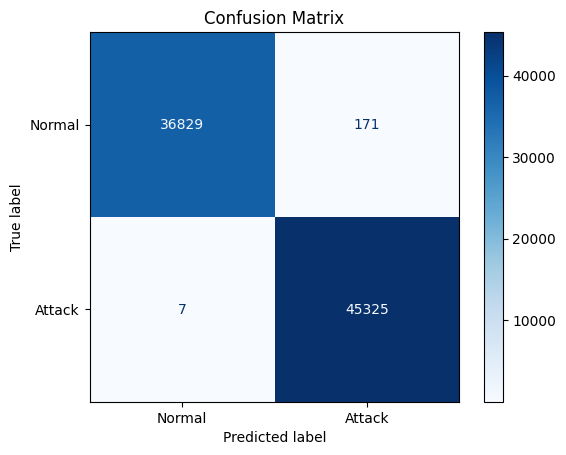

In [9]:
y_test_pred = clf_svm_cv.predict(X_test_scaled)
# Tính ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_test_pred)

# Hiển thị ma trận nhầm lẫn
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Attack'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [10]:
# Tập kiểm tra
y_test_pred = clf_svm_cv.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
loss = hinge_loss(y_test, y_test_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')
print(f'Hinge Loss: {loss}')

Accuracy: 0.9978380216683671
Precision: 0.9962414278178301
Recall: 0.9998455836936381
F1-Score: 0.9980402519046989
Hinge Loss: 0.45156196861487635
